In [1]:
import h5py
from mae import MAEforFMRI
import torch
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


/Users/shaunak/miniconda3/envs/deep_learning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_test_len = int(28088 * 0.9)

In [21]:
class test_fmri_dataset(Dataset):
    def __init__(self):
        super().__init__()

    def __len__(self):
        return 28088 - train_test_len
    
    def __getitem__(self, index):
        data = np.load(f"dataset/UTS01/{index + train_test_len}.npy")
        data = np.nan_to_num(data)
        return torch.tensor(data,  dtype=torch.float32).unsqueeze(0)

In [28]:
class train_fmri_dataset(Dataset):
    def __init__(self):
        super().__init__()

    def __len__(self):
        return train_test_len
    
    def __getitem__(self, index):
        data = np.load(f"dataset/UTS01/{index}.npy")
        data = np.nan_to_num(data)
        return torch.tensor(data,  dtype=torch.float32).unsqueeze(0)

In [29]:
model = MAEforFMRI(num_voxels=81126, patch_size=18, embed_dim=1024, in_chans=1, depth=24, num_heads=16, decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16).to("cpu")
dataset = train_fmri_dataset()
test_data = test_fmri_dataset()
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

print(f"model total paramters: {sum(p.numel() for p in model.parameters()):,}")

model total paramters: 27,450,130


In [30]:
torch.set_default_dtype(torch.float32)
losses = []
optimiser = torch.optim.Adam(model.parameters(), 1e-7)

In [31]:
steps = 0
for epoch in range(1):
    model.train(True)
    for d, data in enumerate(train_dataloader):
        inputs = data.to("cpu")
        optimiser.zero_grad()
        loss, pred, mask = model(inputs)
        print(loss)
        loss.backward()
        optimiser.step()
        print(steps)
        if steps%10 == 0:
            data = next(iter(test_dataloader)).to("cpu")
            loss, pred, mask = model(data)
            print("test loss ---------------------------")
            print(loss)
            losses.append(loss.item())

        steps += 1
    

tensor(2.8886, grad_fn=<DivBackward0>)
0
test loss ---------------------------
tensor(2.8377, grad_fn=<DivBackward0>)
tensor(2.7405, grad_fn=<DivBackward0>)
1
tensor(2.9109, grad_fn=<DivBackward0>)
2
tensor(3.2954, grad_fn=<DivBackward0>)
3
tensor(2.7912, grad_fn=<DivBackward0>)
4
tensor(2.5491, grad_fn=<DivBackward0>)
5
tensor(2.6270, grad_fn=<DivBackward0>)
6
tensor(2.5915, grad_fn=<DivBackward0>)
7
tensor(2.5232, grad_fn=<DivBackward0>)
8
tensor(2.4564, grad_fn=<DivBackward0>)
9
tensor(2.4430, grad_fn=<DivBackward0>)
10
test loss ---------------------------
tensor(2.4167, grad_fn=<DivBackward0>)
tensor(2.7171, grad_fn=<DivBackward0>)
11
tensor(2.3663, grad_fn=<DivBackward0>)
12
tensor(2.3272, grad_fn=<DivBackward0>)
13
tensor(2.3157, grad_fn=<DivBackward0>)
14
tensor(2.1492, grad_fn=<DivBackward0>)
15
tensor(2.1751, grad_fn=<DivBackward0>)
16
tensor(2.0557, grad_fn=<DivBackward0>)
17
tensor(2.2766, grad_fn=<DivBackward0>)
18
tensor(2.2206, grad_fn=<DivBackward0>)
19
tensor(2.0753, g

KeyboardInterrupt: 

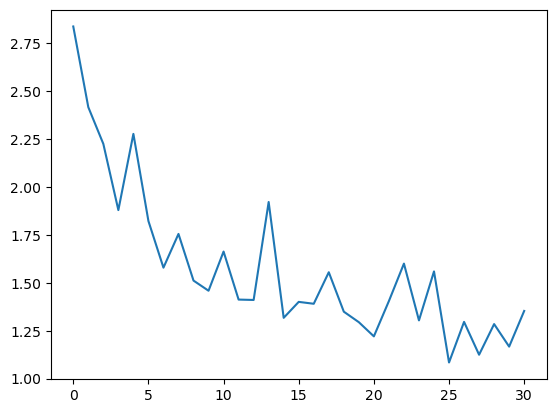

In [32]:
plt.plot(losses)

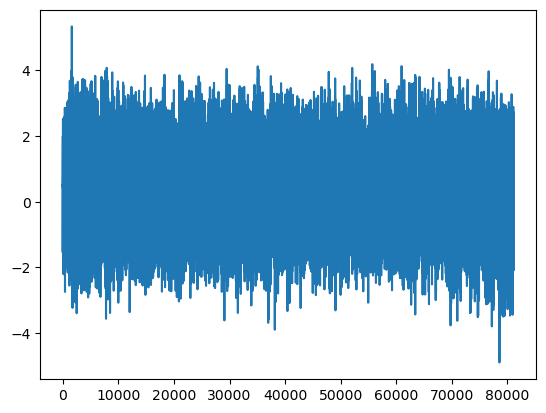

In [25]:
data = data.reshape(-1)
plt.plot(x, data.cpu())